In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import gc  # Python Garbage Collector

# 타임시드 설정
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Sub-pixel Convolution Layer 정의
class SubPixelConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, upscale_factor):
        super(SubPixelConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels * (upscale_factor ** 2), kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)

    def forward(self, x):
        return self.pixel_shuffle(self.conv(x))

# Generator (ESPCN)
class Generator(nn.Module):
    def __init__(self, upscale_factor):
        super(Generator, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            SubPixelConv2d(32, 1, upscale_factor)
        )

    def forward(self, x):
        return self.layers(x)

# 데이터 준비
transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# 디바이스 설정
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# 모델 생성
model_a = Generator(upscale_factor=2).to(device)  # A는 upscale_factor=2
model_b = Generator(upscale_factor=4).to(device)  # B는 upscale_factor=4

optimizer_a = optim.Adam(model_a.parameters(), lr=1e-4)
optimizer_b = optim.Adam(model_b.parameters(), lr=1e-4)

print(device)


mps


In [2]:
# # 학습
# initial_resolution = 28
# next_resolution = initial_resolution
# final_resolution = 128
# max_upscale_factor = 4  # A와 B의 업스케일링 비율에 따라 증가
# prev_output_a = []  # 이전 단계의 A 출력 리스트
# prev_output_b = []  # 이전 단계의 B 출력 리스트

# while next_resolution <= final_resolution:
#     print(f"Starting stage: {next_resolution}x{next_resolution}")

#     current_prev_output_a = []  # 이번 단계의 A 출력 리스트
#     current_prev_output_b = []  # 이번 단계의 B 출력 리스트

#     for epoch in range(1):  # 각 단계에서 1 에포크 학습
#         for batch_idx, (data, _) in enumerate(data_loader):
#             # 데이터 준비
#             data = data.to(device)

#             if next_resolution == initial_resolution:
#                 # 첫 단계에서는 원본 데이터에서 저해상도 생성
#                 current_resolution_a = next_resolution // max_upscale_factor  # A의 입력 해상도
#                 current_resolution_b = next_resolution // max_upscale_factor  # B의 입력 해상도
#                 # 저해상도 입력 생성
#                 low_res_a = nn.functional.interpolate(data, size=(current_resolution_a, current_resolution_a), mode='bilinear', align_corners=False)
#                 low_res_b = nn.functional.interpolate(data, size=(current_resolution_b, current_resolution_b), mode='bilinear', align_corners=False)
#             else:
#                 # 이후 단계에서는 이전 출력 이미지를 리스트에서 가져와 사용
#                 low_res_a = prev_output_a[batch_idx]
#                 low_res_b = prev_output_b[batch_idx]

#             # 모델 A와 B의 출력
#             # A는 두 번 업스케일링
#             output_a_step1 = model_a(low_res_a)
#             output_a = model_a(output_a_step1)  # 두 번째 업스케일
#             output_b = model_b(low_res_b)  # B의 업스케일

#             # 보조값 C 생성: A와 B 출력 해상도에 맞춤
#             target_resolution = output_a.shape[-2:]  # A와 B의 출력 해상도
#             high_res_c = nn.functional.interpolate(data, size=target_resolution, mode='bilinear', align_corners=False)

#             # 평균값 계산 (A, B, C)
#             avg_output = (output_a + output_b + high_res_c) / 3

#             # 각 모델의 손실 (평균값과의 차이 학습)
#             loss_a = nn.MSELoss()(output_a, avg_output)
#             loss_b = nn.MSELoss()(output_b, avg_output)

#             # 총 손실
#             total_loss = loss_a + loss_b

#             # 모델 학습
#             optimizer_a.zero_grad()
#             optimizer_b.zero_grad()
#             total_loss.backward()
#             optimizer_a.step()
#             optimizer_b.step()

#             # 이번 단계의 출력을 저장
#             current_prev_output_a.append(output_a.detach())
#             current_prev_output_b.append(output_b.detach())

#             # 출력
#             if batch_idx % 100 == 0:
#                 print(f"Epoch [{epoch+1}/3], Batch [{batch_idx}/{len(data_loader)}], Loss A: {loss_a.item():.4f}, Loss B: {loss_b.item():.4f}")

#     # 현재 단계가 끝나면 출력을 저장
#     prev_output_a = current_prev_output_a
#     prev_output_b = current_prev_output_b

#     print(f"Finished stage: {next_resolution}x{next_resolution}")
#     print(f"prev_output_a size: {len(prev_output_a)}, prev_output_b size: {len(prev_output_b)}")

#     # 다음 단계로 해상도 증가
#     next_resolution *= max_upscale_factor


Starting stage: 28x28
Epoch [1/3], Batch [0/1875], Loss A: 0.0219, Loss B: 0.0271
Epoch [1/3], Batch [100/1875], Loss A: 0.0063, Loss B: 0.0072
Epoch [1/3], Batch [200/1875], Loss A: 0.0054, Loss B: 0.0055
Epoch [1/3], Batch [300/1875], Loss A: 0.0044, Loss B: 0.0043
Epoch [1/3], Batch [400/1875], Loss A: 0.0038, Loss B: 0.0038
Epoch [1/3], Batch [500/1875], Loss A: 0.0034, Loss B: 0.0033
Epoch [1/3], Batch [600/1875], Loss A: 0.0035, Loss B: 0.0035
Epoch [1/3], Batch [700/1875], Loss A: 0.0032, Loss B: 0.0032
Epoch [1/3], Batch [800/1875], Loss A: 0.0033, Loss B: 0.0033
Epoch [1/3], Batch [900/1875], Loss A: 0.0031, Loss B: 0.0032
Epoch [1/3], Batch [1000/1875], Loss A: 0.0030, Loss B: 0.0029
Epoch [1/3], Batch [1100/1875], Loss A: 0.0029, Loss B: 0.0029
Epoch [1/3], Batch [1200/1875], Loss A: 0.0027, Loss B: 0.0027
Epoch [1/3], Batch [1300/1875], Loss A: 0.0028, Loss B: 0.0027
Epoch [1/3], Batch [1400/1875], Loss A: 0.0033, Loss B: 0.0033
Epoch [1/3], Batch [1500/1875], Loss A: 0.002

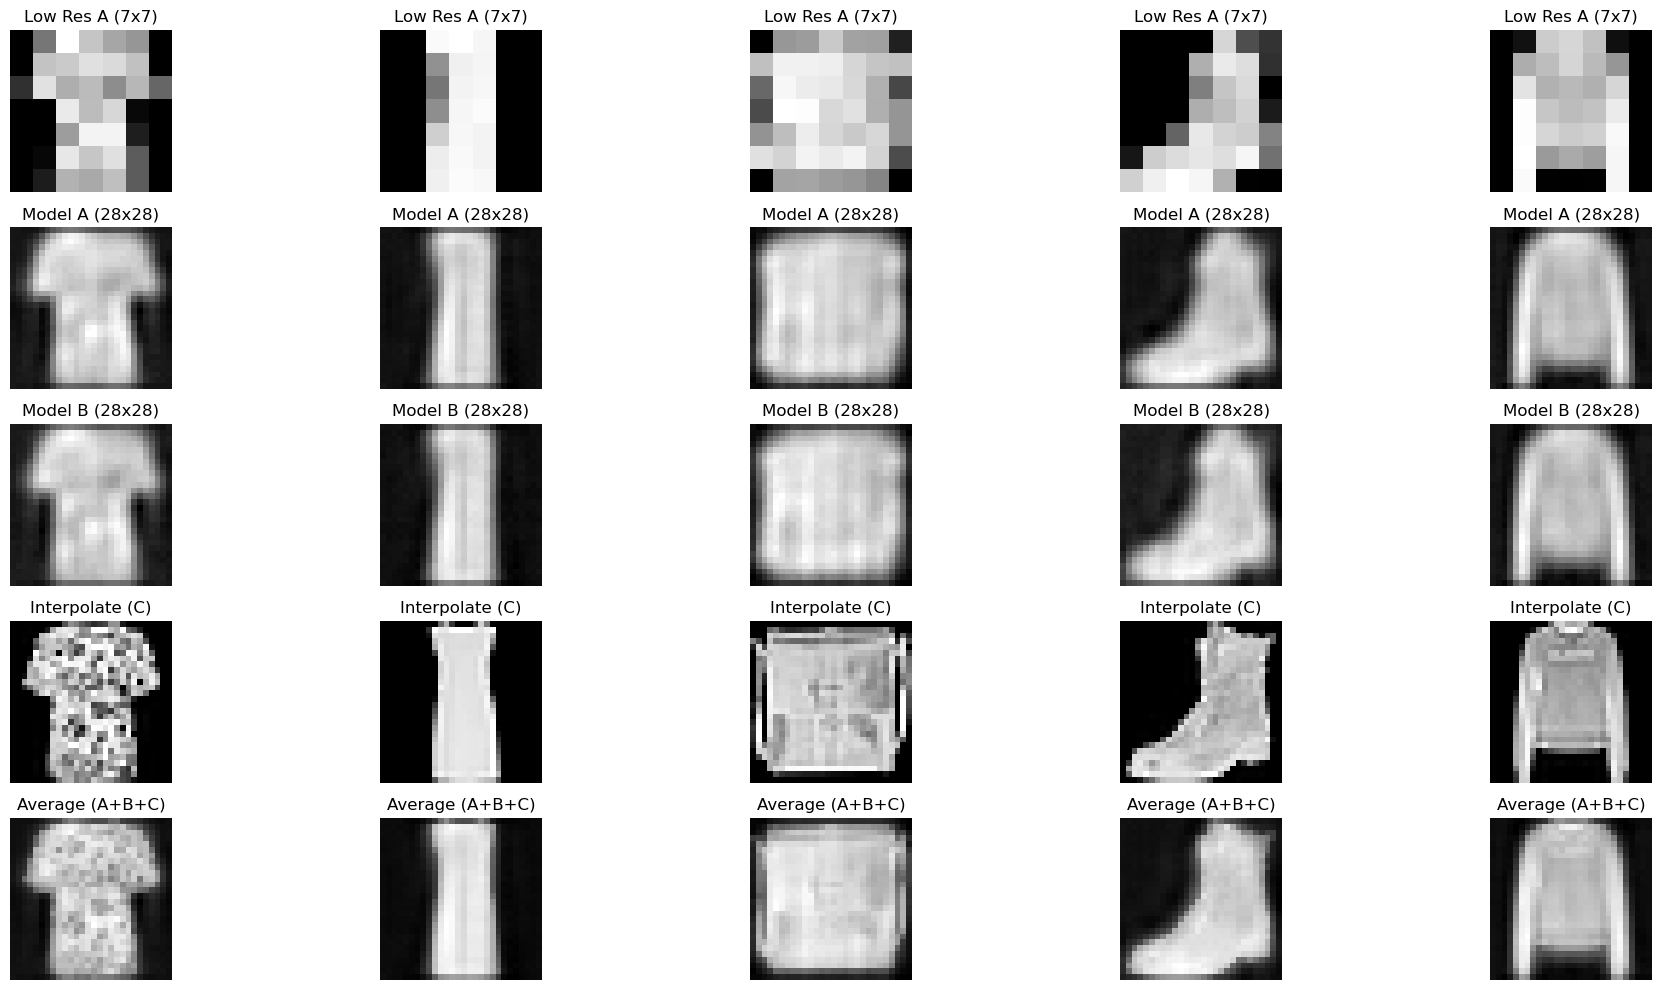

Starting stage: 112x112
Epoch [1/3], Batch [0/1875], Loss A: 0.0217, Loss B: 0.0235
Epoch [1/3], Batch [100/1875], Loss A: 0.0105, Loss B: 0.0106
Epoch [1/3], Batch [200/1875], Loss A: 0.0098, Loss B: 0.0100
Epoch [1/3], Batch [300/1875], Loss A: 0.0117, Loss B: 0.0119
Epoch [1/3], Batch [400/1875], Loss A: 0.0093, Loss B: 0.0097
Epoch [1/3], Batch [500/1875], Loss A: 0.0102, Loss B: 0.0103
Epoch [1/3], Batch [600/1875], Loss A: 0.0103, Loss B: 0.0107
Epoch [1/3], Batch [700/1875], Loss A: 0.0100, Loss B: 0.0103


RuntimeError: MPS backend out of memory (MPS allocated: 18.10 GB, other allocations: 11.45 MB, max allowed: 18.13 GB). Tried to allocate 24.50 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [3]:
# 학습
epoch_num = 3
initial_resolution = 28
next_resolution = initial_resolution
final_resolution = 128
prev_output_a = None  # 이전 단계의 A 출력
prev_output_b = None  # 이전 단계의 B 출력
max_upscale_factor = 4  # A, B의 upscale_factor 최소 공배수

while next_resolution <= final_resolution:
    print(f"Starting stage: {next_resolution}x{next_resolution}")

    current_prev_output_a = []  # 이번 단계의 A 출력 리스트
    current_prev_output_b = []  # 이번 단계의 B 출력 리스트

    for epoch in range(3):  # 각 단계에서 3 에포크 학습
        for batch_idx, (data, _) in enumerate(data_loader):
            # 데이터 준비
            data = data.to(device)

            if next_resolution == initial_resolution:
                # 첫 단계에서는 원본 데이터에서 저해상도 생성
                current_resolution_a = next_resolution // 4  # A의 입력 해상도
                current_resolution_b = next_resolution // 4  # B의 입력 해상도
                # 저해상도 입력 생성
                low_res_a = nn.functional.interpolate(data, size=(current_resolution_a, current_resolution_a), mode='bilinear', align_corners=False)
                low_res_b = nn.functional.interpolate(data, size=(current_resolution_b, current_resolution_b), mode='bilinear', align_corners=False)
            else:
                # 이후 단계에서는 이전 출력 이미지를 리스트에서 가져와 사용
                low_res_a = prev_output_a[batch_idx]
                low_res_b = prev_output_b[batch_idx]

            # 모델 A와 B의 출력
            # A는 두 번 업스케일링
            output_a_step1 = model_a(low_res_a)
            output_a = model_a(output_a_step1)  # 두 번째 업스케일
            output_b = model_b(low_res_b)  # B의 업스케일

            # 보조값 C 생성: A와 B 출력 해상도에 맞춤
            target_resolution = output_a.shape[-2:]  # A와 B의 출력 해상도
            high_res_c = nn.functional.interpolate(data, size=target_resolution, mode='bilinear', align_corners=False)

            # 평균값 계산 (A, B, C)
            avg_output = (output_a + output_b + high_res_c) / 3

            # 각 모델의 손실 (평균값과의 차이 학습)
            loss_a = nn.MSELoss()(output_a, avg_output)
            loss_b = nn.MSELoss()(output_b, avg_output)

            # 총 손실
            total_loss = loss_a + loss_b

            # 모델 학습
            optimizer_a.zero_grad()
            optimizer_b.zero_grad()
            total_loss.backward()
            optimizer_a.step()
            optimizer_b.step()

            # 이번 단계의 출력을 저장
            current_prev_output_a.append(output_a.detach())
            current_prev_output_b.append(output_b.detach())

            # 출력
            if batch_idx % 100 == 0:
                print(f"Epoch [{epoch+1}/3], Batch [{batch_idx}/{len(data_loader)}], Loss A: {loss_a.item():.4f}, Loss B: {loss_b.item():.4f}")

            # 에포크 종료 후 메모리 캐시 정리
            torch.cuda.empty_cache()
            gc.collect()  # CPU 메모리 정리

        # 학습 마지막 에포크에서 출력
        if epoch == epoch_num-1:  # 마지막 에포크
            with torch.no_grad():
                print(f"Displaying results for resolution: {next_resolution}x{next_resolution}")
                plt.figure(figsize=(20, 10))
                for i in range(5):  # 5개의 샘플 출력
                    # 저해상도 A
                    plt.subplot(5, 5, i + 1)
                    plt.imshow(low_res_a[i].squeeze().cpu().numpy(), cmap='gray')
                    plt.title(f"Low Res A ({target_resolution[0] // max_upscale_factor}x{target_resolution[0] // max_upscale_factor})")
                    plt.axis('off')

                    # A의 결과
                    plt.subplot(5, 5, i + 6)
                    plt.imshow(output_a[i].squeeze().cpu().numpy(), cmap='gray')
                    plt.title(f"Model A ({target_resolution[0]}x{target_resolution[1]})")
                    plt.axis('off')

                    # B의 결과
                    plt.subplot(5, 5, i + 11)
                    plt.imshow(output_b[i].squeeze().cpu().numpy(), cmap='gray')
                    plt.title(f"Model B ({target_resolution[0]}x{target_resolution[1]})")
                    plt.axis('off')

                    # 보조값 C
                    plt.subplot(5, 5, i + 16)
                    plt.imshow(high_res_c[i].squeeze().cpu().numpy(), cmap='gray')
                    plt.title("Interpolate (C)")
                    plt.axis('off')

                    # 평균값
                    plt.subplot(5, 5, i + 21)
                    plt.imshow(avg_output[i].squeeze().cpu().numpy(), cmap='gray')
                    plt.title("Average (A+B+C)")
                    plt.axis('off')

                plt.tight_layout()
                plt.show()

            # 에포크 종료 후 메모리 캐시 정리
            torch.cuda.empty_cache()
            gc.collect()  # CPU 메모리 정리

        # 각 단계가 끝나면 A와 B의 출력 이미지를 다음 단계 입력으로 저장
        prev_output_a = current_prev_output_a  # 다음 단계의 저해상도로 사용
        prev_output_b = current_prev_output_b

    # 다음 단계로 해상도 증가
    next_resolution *= max_upscale_factor
